# Data info.
* Y_Class : 제품 품질 상태(Target) 
 * 0 : 적정 기준 미달 (부적합)
 * 1 : 적합
 * 2 : 적정 기준 초과 (부적합)
* Y_Quality : 제품 품질 관련 정량적 수치
* TIMESTAMP : 제품이 공정에 들어간 시각
* LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
* PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
* X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수

# LINE과 CODE별로 예측해보자

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import os
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# Data Load

In [38]:
train_df = pd.read_csv('Dacon_data/train.csv')
test_df = pd.read_csv('Dacon_data/test.csv')

In [39]:
train_df.head()

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN


# Data Pre-processing

In [40]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)
train_df.head()

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,0.0,0.0,0.0,0.0,...,39.34,40.89,32.56,34.09,77.77,0.0,0.0,0.0,0.0,0.0
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,0.0,0.0,0.0,0.0,...,38.89,42.82,43.92,35.34,72.55,0.0,0.0,0.0,0.0,0.0
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,0.0,0.0,0.0,0.0,...,39.19,36.65,42.47,36.53,78.35,0.0,0.0,0.0,0.0,0.0
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,0.0,0.0,0.0,0.0,...,37.74,39.17,52.17,30.58,71.78,0.0,0.0,0.0,0.0,0.0
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,0.0,0.0,0.0,0.0,...,38.70,41.89,46.93,33.09,76.97,0.0,0.0,0.0,0.0,0.0


In [41]:
train_x = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Class', 'Y_Quality'])
train_y = train_df['Y_Class']

test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])
train_x

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.34,40.89,32.56,34.09,77.77,0.0,0.0,0.0,0.0,0.0
1,T050307,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,38.89,42.82,43.92,35.34,72.55,0.0,0.0,0.0,0.0,0.0
2,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.19,36.65,42.47,36.53,78.35,0.0,0.0,0.0,0.0,0.0
3,T050307,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,37.74,39.17,52.17,30.58,71.78,0.0,0.0,0.0,0.0,0.0
4,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,38.70,41.89,46.93,33.09,76.97,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,50.0,10.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
594,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,49.47,53.07,50.89,55.10,66.49,1.0,0.0,0.0,0.0,0.0
595,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,1.0,0.0,0.0,0.0,0.0
596,T100304,O_31,40.0,94.0,0.0,45.0,11.0,0.0,45.0,10.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0


In [42]:
from sklearn.preprocessing import StandardScaler

# 정규화를 위해 StandardScaler.
# 신경망 학습시 데이터셋의 값이 들쑥날쑥하거나, 매우 큰 경우에는 cost의 값이 발산하여 정상적인 학습이 이루어지지 않아
sc = StandardScaler().fit(train_x[train_x.columns[2:]])

# train_x에 있는 데이터에 맞춰 정규화를 진행. 
train_x[train_x.columns[2:]] = sc.fit_transform(train_x[train_x.columns[2:]])
# train_x = sc.fit_transform(train_x[train_x.columns[2:]]) # train은 fit_transform test는 transform

test_x[test_x.columns[2:]] = sc.transform(test_x[test_x.columns[2:]])
# test_x = sc.transform(test_x[test_x.columns[2:]])

test_x

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,T100306,T_31,0.127626,0.818890,0.0,0.844670,0.766018,0.0,0.927147,0.834377,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
1,T100304,T_31,0.127626,0.797612,0.0,0.844670,0.960697,0.0,0.680110,0.834377,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
2,T100304,T_31,0.127626,0.840168,0.0,0.844670,0.960697,0.0,0.680110,0.834377,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
3,T010305,A_31,-0.302348,-1.181260,0.0,-1.183895,-1.180768,0.0,-1.172670,-1.183243,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
4,T010306,A_31,-0.302348,-1.181260,0.0,-1.183895,-1.180768,0.0,-1.172670,-1.183243,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,T100306,T_31,0.127626,0.755056,0.0,0.844670,0.766018,0.0,0.927147,0.834377,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
306,T100304,T_31,0.127626,0.861447,0.0,0.844670,0.960697,0.0,0.680110,0.834377,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
307,T100306,T_31,0.127626,0.755056,0.0,0.844670,0.766018,0.0,0.885975,0.834377,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
308,T100306,T_31,0.127626,0.840168,0.0,0.844670,0.766018,0.0,0.927147,0.834377,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0


In [43]:
# #mean()으로 평균을 구하고 var()로 분산.
# x_train_sc = pd.DataFrame(data=train_x)
# print("평균")
# print(x_train_sc.mean())
# print("분산")
# print(x_train_sc.var())

In [44]:
# x_train_sc

In [45]:
# # qualitative to quantitative
# qual_col = ['LINE', 'PRODUCT_CODE']

# for i in qual_col:
#     le = LabelEncoder()
#     le = le.fit(train_x[i])
#     train_x[i] = le.transform(train_x[i])
    
#     for label in np.unique(test_x[i]): 
#         if label not in le.classes_: 
#             le.classes_ = np.append(le.classes_, label)
#     test_x[i] = le.transform(test_x[i]) 
# train_x

In [46]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct_1 = ColumnTransformer(transformers=[('encoder', OneHotEncoder(drop='first'),[0])],remainder='passthrough')
# 원핫인코더에서 다중공선성 문제를 해결하고자 drop='first'
# 어떤데이터를 가지고 원핫할건지를 선택 나는 LINE을가지고 원핫하고자하기에 [0]
# 나머지칼럼들은 그대로 두기위해 remainder='passthrough'
train_x = ct_1.fit_transform(train_x)

pd.DataFrame(train_x)

,0,1,2,3,4,5,6,7,8,9,...,2871,2872,2873,2874,2875,2876,2877,2878,2879,2880
0,0.0,1.0,0.0,0.0,0.0,A_31,-0.302348,-1.18126,0.0,-1.183895,...,1.608668,1.574442,1.294833,1.297452,2.671373,-0.445418,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,A_31,-0.302348,-1.18126,0.0,-1.183895,...,1.585198,1.669622,1.901036,1.361174,2.462073,-0.445418,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,A_31,-0.302348,-1.18126,0.0,-1.183895,...,1.600845,1.365342,1.82366,1.421838,2.694629,-0.445418,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,A_31,-0.302348,-1.18126,0.0,-1.183895,...,1.525219,1.489618,2.34128,1.118519,2.431199,-0.445418,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,A_31,-0.302348,-1.18126,0.0,-1.183895,...,1.575288,1.623758,2.061658,1.246474,2.639297,-0.445418,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,0.0,0.0,0.0,0.0,1.0,T_31,0.127626,0.840168,0.0,0.84467,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
594,0.0,1.0,0.0,0.0,0.0,A_31,-0.302348,-1.18126,0.0,-1.183895,...,2.137001,2.175113,2.272976,2.368498,2.219091,2.245084,0.0,0.0,0.0,0.0
595,0.0,1.0,0.0,0.0,0.0,A_31,-0.302348,-1.18126,0.0,-1.183895,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,2.245084,0.0,0.0,0.0,0.0
596,0.0,0.0,0.0,1.0,0.0,O_31,8.297142,0.81889,0.0,0.84467,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0


In [47]:
ct_2 = ColumnTransformer(transformers=[('encoder', OneHotEncoder(drop='first'),[5])],remainder='passthrough')
# CODE를을가지고 원핫하고자하기에 [5]
train_x = ct_2.fit_transform(train_x)
pd.DataFrame(train_x)
# 아래데이터를 보면 0,1 column은 CODE를 원핫, 2,3,4,5,6은 LINE을 원핫 한것이다.

,0,1,2,3,4,5,6,7,8,9,...,2872,2873,2874,2875,2876,2877,2878,2879,2880,2881
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.302348,-1.18126,0.0,...,1.608668,1.574442,1.294833,1.297452,2.671373,-0.445418,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.302348,-1.18126,0.0,...,1.585198,1.669622,1.901036,1.361174,2.462073,-0.445418,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.302348,-1.18126,0.0,...,1.600845,1.365342,1.82366,1.421838,2.694629,-0.445418,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.302348,-1.18126,0.0,...,1.525219,1.489618,2.34128,1.118519,2.431199,-0.445418,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.302348,-1.18126,0.0,...,1.575288,1.623758,2.061658,1.246474,2.639297,-0.445418,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.127626,0.840168,0.0,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
594,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.302348,-1.18126,0.0,...,2.137001,2.175113,2.272976,2.368498,2.219091,2.245084,0.0,0.0,0.0,0.0
595,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.302348,-1.18126,0.0,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,2.245084,0.0,0.0,0.0,0.0
596,1.0,0.0,0.0,0.0,0.0,1.0,0.0,8.297142,0.81889,0.0,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0


In [48]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct_1 = ColumnTransformer(transformers=[('encoder', OneHotEncoder(drop='first'),[0])],remainder='passthrough')
# 원핫인코더에서 다중공선성 문제를 해결하고자 drop='first'
# 어떤데이터를 가지고 원핫할건지를 선택 나는 LINE을가지고 원핫하고자하기에 [0]
# 나머지칼럼들은 그대로 두기위해 remainder='passthrough'
test_x = ct_1.fit_transform(test_x)

pd.DataFrame(test_x)

,0,1,2,3,4,5,6,7,8,9,...,2871,2872,2873,2874,2875,2876,2877,2878,2879,2880
0,0.0,0.0,0.0,0.0,1.0,T_31,0.127626,0.81889,0.0,0.84467,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,T_31,0.127626,0.797612,0.0,0.84467,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,T_31,0.127626,0.840168,0.0,0.84467,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,A_31,-0.302348,-1.18126,0.0,-1.183895,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,A_31,-0.302348,-1.18126,0.0,-1.183895,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,0.0,0.0,0.0,0.0,1.0,T_31,0.127626,0.755056,0.0,0.84467,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
306,0.0,0.0,0.0,1.0,0.0,T_31,0.127626,0.861447,0.0,0.84467,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
307,0.0,0.0,0.0,0.0,1.0,T_31,0.127626,0.755056,0.0,0.84467,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
308,0.0,0.0,0.0,0.0,1.0,T_31,0.127626,0.840168,0.0,0.84467,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0


In [49]:
ct_2 = ColumnTransformer(transformers=[('encoder', OneHotEncoder(drop='first'),[5])],remainder='passthrough')
# CODE를을가지고 원핫하고자하기에 [5]
test_x = ct_2.fit_transform(test_x)
pd.DataFrame(test_x)
# 아래데이터를 보면 0,1 column은 CODE를 원핫, 2,3,4,5,6은 LINE을 원핫 한것이다.

,0,1,2,3,4,5,6,7,8,9,...,2872,2873,2874,2875,2876,2877,2878,2879,2880,2881
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.127626,0.81889,0.0,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.127626,0.797612,0.0,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.127626,0.840168,0.0,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.302348,-1.18126,0.0,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.302348,-1.18126,0.0,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.127626,0.755056,0.0,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
306,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.127626,0.861447,0.0,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
307,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.127626,0.755056,0.0,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
308,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.127626,0.840168,0.0,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0


In [50]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=0)
# 훈련 80 테스트 20으로 분리.

In [15]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(x_train, y_train)

C:\Users\rkdls\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### 예측값과 실제값 비교(테스트셋)

In [16]:
classifier.score(x_train, y_train)

0.9916317991631799

In [17]:
classifier.score(x_test, y_test)

0.6666666666666666

In [30]:
x_test.shape, y_test.shape

((120, 2882), (120,))

In [18]:
# preds = classifier.predict(test_x)
# preds

array([1, 1, 1, 0, 2, 2, 0, 2, 2, 1, 1, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 2, 2, 2, 1,
       1, 1, 1, 1, 2, 0, 1, 1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0,
       2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 2,
       2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,

In [51]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [24]:
models = []
models.append(('LDA', LinearDiscriminantAnalysis()))  # LDA 모델
models.append(('KNN', KNeighborsClassifier()))  # KNN 모델
models.append(('CART', DecisionTreeClassifier()))  # 의사결정트리 모델
models.append(('NB', GaussianNB()))  # 가우시안 나이브 베이즈 모델
models.append(('RF', RandomForestClassifier()))  # 랜덤포레스트 모델
models.append(('SVM', SVC(gamma='auto')))  # SVM 모델
models.append(('XGB', XGBClassifier()))  # XGB 모델

for name, model in models:
    model.fit(x_train, y_train)

    msg = "%s - train_score : %f, test score : %f" % (name, model.score(x_train, y_train), model.score(x_test, y_test))
    print(msg)

LDA - train_score : 0.202929, test score : 0.333333


C:\Users\rkdls\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rkdls\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

KNN - train_score : 0.809623, test score : 0.716667
CART - train_score : 1.000000, test score : 0.641667
NB - train_score : 0.612971, test score : 0.616667
RF - train_score : 1.000000, test score : 0.783333
SVM - train_score : 0.732218, test score : 0.741667
XGB - train_score : 1.000000, test score : 0.775000


In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
k=1
clf = KNeighborsClassifier(n_neighbors=k).fit(x_train, y_train)
print(clf)

yhat = clf.predict(x_test)
print("Train set Accuracy : ", metrics.accuracy_score(y_train, clf.predict(x_train)))
print("Test set Accuracy : ", metrics.accuracy_score(y_test, clf.predict(x_test)))

KNeighborsClassifier(n_neighbors=1)


C:\Users\rkdls\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rkdls\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Train set Accuracy :  1.0
Test set Accuracy :  0.6166666666666667


C:\Users\rkdls\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [53]:
# 최적의 K 찾기
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1, Ks):
    clf = KNeighborsClassifier(n_neighbors=n).fit(x_train, y_train)
    yhat = clf.predict(x_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    
print(mean_acc)

C:\Users\rkdls\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rkdls\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[0.61666667 0.65833333 0.675      0.73333333 0.71666667 0.71666667
 0.70833333 0.70833333 0.725     ]


C:\Users\rkdls\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


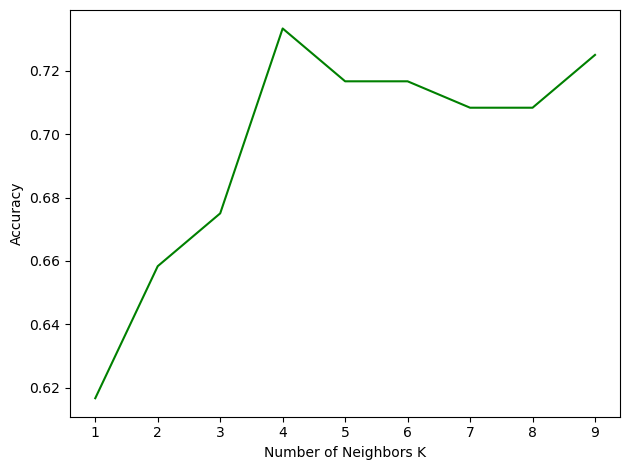

In [54]:
plt.plot(range(1,Ks), mean_acc, 'g')
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors K')
plt.tight_layout()
plt.show()
# 최적의 KNN값은 4인것을 알 수 있어.

In [55]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
k=4 # 최적의값이다.
clf = KNeighborsClassifier(n_neighbors=k).fit(x_train, y_train)
print(clf)

yhat = clf.predict(x_test)
print("Train set Accuracy : ", metrics.accuracy_score(y_train, clf.predict(x_train)))
print("Test set Accuracy : ", metrics.accuracy_score(y_test, clf.predict(x_test)))

KNeighborsClassifier(n_neighbors=4)
Train set Accuracy :  0.8263598326359832


C:\Users\rkdls\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rkdls\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Test set Accuracy :  0.7333333333333333


C:\Users\rkdls\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [56]:
preds = clf.predict(test_x)
preds

C:\Users\rkdls\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


array([1, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0,
       0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,

In [36]:
submit = pd.read_csv('Dacon_data/sample_submission.csv')
submit['Y_Class'] = preds
submit
submit.to_csv('Dacon_data/sample_submission.csv', index=False)